In [27]:
import librosa
import numpy as np
import math
import scipy
import librosa.display
import librosa.decompose
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Audio

In [39]:
d = {}

pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\min6dB\pump\id_04\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\min6dB\pump\id_04\abnormal\00000000.wav'    
d['pump'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\fan\id_00\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\fan\id_00\abnormal\00000000.wav'    
d['fan'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\slider\id_02\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\slider\id_02\abnormal\00000000.wav'    
d['slider'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\valve\id_06\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\valve\id_06\abnormal\00000000.wav'    
d['valve'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}

sr = d['pump']['n'][1]

In [122]:
def fft_freq_axis_hz(pnts,srate):
    return np.linspace(0,srate/2,num=math.floor(pnts/2.)+1)

def fft_amp_scaled_abs(fCoefs,fpos_range=[]):
    if type(fpos_range) is np.ndarray:
        fpos_range = len(fpos_range)
    else:
        if not fpos_range:
            fpos_range = len(fCoefs)
    
    return 2*np.abs(fCoefs)[0:fpos_range] / len(fCoefs)

def fft_amp2power_abs(amps):
    return amps*amps;

def fft_phase(fCoefs, fpos_range=[]):
    if type(fpos_range) is np.ndarray:
        fpos_range = len(fpos_range)
    else:
        if not fpos_range:
            fpos_range = len(fCoefs)
            
    return np.angle(fCoefs)[0:fpos_range]

def phase_read2deg(p):
     return p*(180/np.pi)

def fft_complete(signal,srate):
    pnts = len(signal)
    fCoefs = np.fft.fft(signal) 
    hz = fft_freq_axis_hz(pnts,srate)
    amp = fft_amp_scaled_abs(fCoefs,hz)
    pwr = fft_amp2power_abs(amp)
    ph = fft_phase(fCoefs, hz)
    ph_deg = phase_read2deg(ph)
    return fCoefs,hz,amp,pwr,ph,ph_deg

def P2R(radii, angles):
    return radii * np.exp(1j*angles)

def R2P(x):
    return np.abs(x), np.angle(x)

def HardBandKill(fCoefs,limit,weight=0):
    rFc = np.zeros(len(fCoefs))
    for i in range(len(fCoefs)):
        amp, ph = R2P(fCoefs[i])
        #print(amp)
        if amp>=limit:
            rFc[i]=P2R(amp,ph)
        else:
            #print('####')
            rFc[i]=P2R(amp*weight,ph)
            
   
    return rFc
        

(160000,) (80001,)


C:\ProgramData\Anaconda3\envs\mimiibaseTF2GPU\lib\site-packages\ipykernel_launcher.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\envs\mimiibaseTF2GPU\lib\site-packages\ipykernel_launcher.py:50: ComplexWarning: Casting complex values to real discards the imaginary part


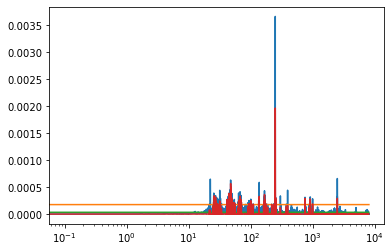

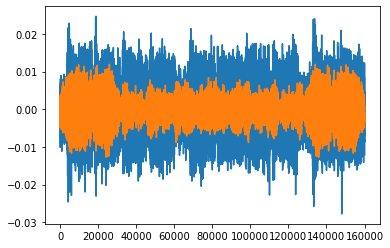

In [125]:
y = d['slider']['n'][0][0]
fCoefs,hz,amp,pwr,ph,ph_deg = fft_complete(y,sr)
print(fCoefs.shape,amp.shape)
plt.plot(hz,amp)
limit = np.mean(np.abs(fCoefs))+np.std(np.abs(fCoefs))*6
plt.plot(hz,np.ones(len(amp))* np.mean(amp)+np.std(amp)*6)
plt.plot(hz,np.ones(len(amp))* np.mean(amp[np.where(hz<1000)]))
limit1k = np.mean(amp[np.where(hz<1000)])*4
fCoefsDenoise =  fCoefs
#fCoefsDenoise[np.where(amp<limit)]=0
#fCoefsDenoise[np.where(np.logical_and(hz<1000,amp<limit1k))] = 0
fCoefsDenoise=HardBandKill(fCoefs,limit,0.03)

denoised = np.fft.ifft(fCoefsDenoise)
display(Audio(data=y,rate=sr))
display(Audio(data=denoised.real,rate=sr))
fCoefsde,hz,amp,pwr,ph,ph_deg = fft_complete(denoised.real,sr)
plt.plot(hz,amp)
plt.xscale('log')
plt.show()
plt.plot(y)
plt.plot(denoised.real)


In [46]:
np.mean(amp[np.where(hz<1000)])

1.0562183044952994e-05

In [49]:
amp[np.where(np.logical_and(hz<1000,amp>limit1k))]

NameError: name 'limit1k' is not defined

In [33]:
Audio(data=y,rate=sr)

In [36]:
Audio(data=denoised.real,rate=sr)

In [35]:
denoised

array([ 0.00412018-0.0032797j ,  0.00054068-0.00181055j,
       -0.00057651-0.00016636j, ...,  0.0035898 +0.00288544j,
        0.00488904+0.00230211j,  0.00628289-0.00125693j])